In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
tf.__version__

'2.10.1'

In [12]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    # Path to your pic folder
    folder_path = os.path.join(r"C:\Users\zhang\Downloads\kagglecatsanddogs_5340\PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1578 images


In [14]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    # Path to your pic folder
    r"C:\Users\zhang\Downloads\kagglecatsanddogs_5340\PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


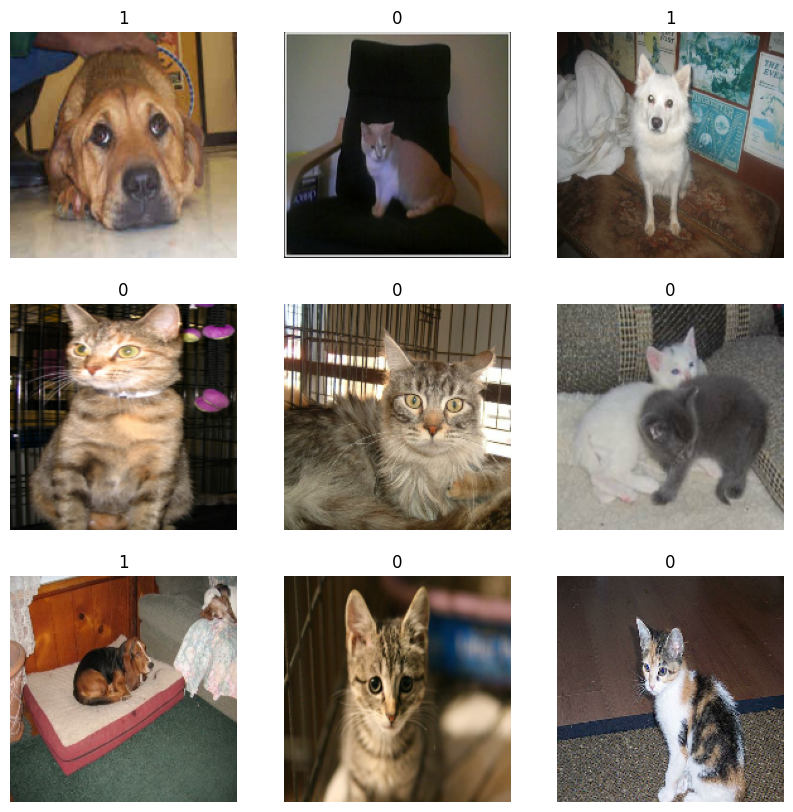

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

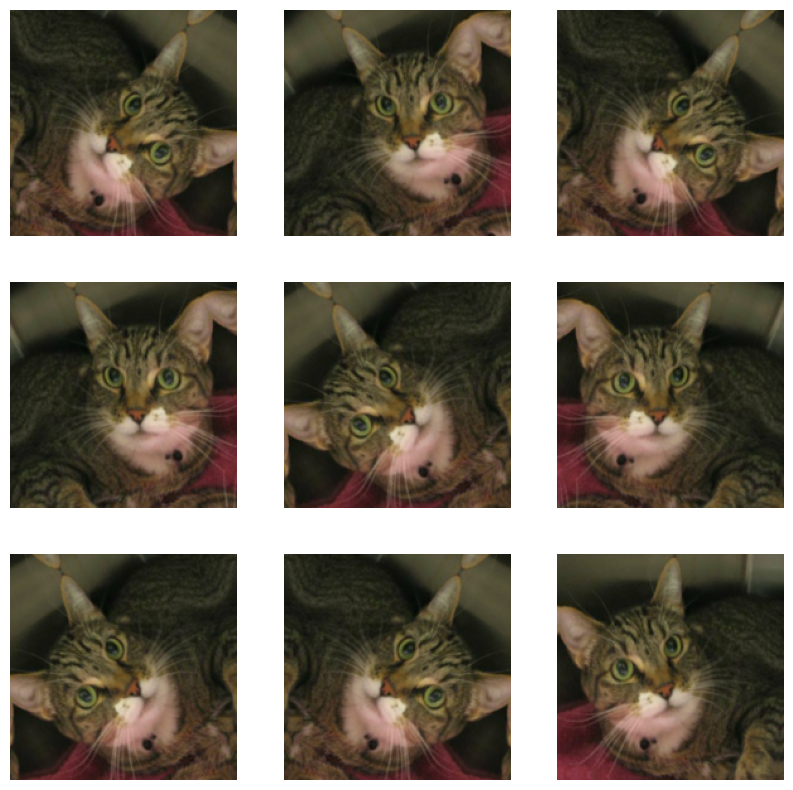

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [18]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [20]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(2, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [4, 8, 16]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save/save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 [==============================] - 19s 74ms/step - loss: 0.6856 - accuracy: 0.5813 - val_loss: 0.7864 - val_accuracy: 0.4957
Epoch 2/25
147/147 [==============================] - 12s 78ms/step - loss: 0.6548 - accuracy: 0.6187 - val_loss: 0.9254 - val_accuracy: 0.4957
Epoch 3/25
147/147 [==============================] - 12s 75ms/step - loss: 0.6358 - accuracy: 0.6438 - val_loss: 0.7522 - val_accuracy: 0.5329
Epoch 4/25
147/147 [==============================] - 12s 76ms/step - loss: 0.6246 - accuracy: 0.6563 - val_loss: 0.6132 - val_accuracy: 0.6637
Epoch 5/25
147/147 [==============================] - 12s 77ms/step - loss: 0.6145 - accuracy: 0.6628 - val_loss: 0.5924 - val_accuracy: 0.6881
Epoch 6/25
147/147 [==============================] - 12s 78ms/step - loss: 0.6094 - accuracy: 0.6709 - val_loss: 0.5841 - val_accuracy: 0.7011
Epoch 7/25
147/147 [==============================] - 12s 78ms/step - loss: 0.6028 - accuracy: 0.6778 - val_loss: 0.5882 - val_accuracy:

1/1 [==============================] - 0s 12ms/step
This image is 63.55% cat and 36.45% dog.


C:\Users\zhang\AppData\Local\Temp\ipykernel_10492\3199354065.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[0])


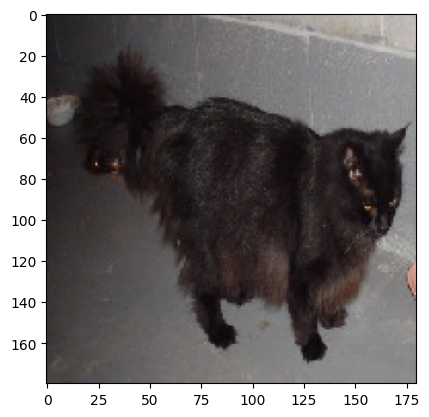

In [28]:
img = keras.utils.load_img(
    r"C:\Users\zhang\Downloads\kagglecatsanddogs_5340\PetImages\Cat\9976.jpg",
    target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")